In [119]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import seaborn as sns
from time import time
from math import sqrt

In [120]:
#timing detector
def timeit(fn):
    def wrapper(*args, **kwargs):
        start=time()
        res=fn(*args, **kwargs)
        print(fn.__name__, "took", time()-start, "seconds.")
        return res
    return wrapper

In [121]:
control_data_path=os.path.join('data', 'control')
parkinson_data_path=os.path.join('data', 'parkinson')

In [122]:
control_file_list=[os.path.join(control_data_path, x) for x in os.listdir(control_data_path)]
parkinson_file_list=[os.path.join(parkinson_data_path, x) for x in os.listdir(parkinson_data_path)]

In [123]:
header_row=["X", "Y", "Z", "Pressure" , "GripAngle" , "Timestamp" , "Test_ID"]

In [124]:
#@timeit
def get_no_strokes(df):
    pressure_data=df['Pressure'].to_numpy()
    on_surface = (pressure_data>600).astype(int)
    return ((np.roll(on_surface, 1) - on_surface) != 0).astype(int).sum()

In [125]:
#@timeit
def get_speed(df):
    total_dist=0
    duration=df['Timestamp'].to_numpy()[-1]
    coords=df[['X', 'Y', 'Z']].to_numpy()
    for i in range(10, df.shape[0]):
        temp=np.linalg.norm(coords[i, :]-coords[i-10, :])
        total_dist+=temp
    speed=total_dist/duration
    return speed

In [126]:
#@timeit
def get_in_air_time(data):
    data=data['Pressure'].to_numpy()
    return (data<600).astype(int).sum()

In [127]:
#@timeit
def get_on_surface_time(data):
    data=data['Pressure'].to_numpy()
    return (data>600).astype(int).sum()

In [128]:
def find_velocity(f):
    '''
    change in direction and its position
    
    '''
    data_pat=f
    Vel = []
    horz_Vel = []
    horz_vel_mag = []
    vert_vel_mag = []
    vert_Vel = []
    magnitude = []
    timestamp_diff =  []
    
    t = 0
    for i in range(len(data_pat)-2):
        if t+10 <= len(data_pat)-1:
            Vel.append(((data_pat['X'].to_numpy()[t+10] - data_pat['X'].to_numpy()[t])/(data_pat['Timestamp'].to_numpy()[t+10]-data_pat['Timestamp'].to_numpy()[t]) , (data_pat['Y'].to_numpy()[t+10]-data_pat['Y'].to_numpy()[t])/(data_pat['Timestamp'].to_numpy()[t+10]-data_pat['Timestamp'].to_numpy()[t])))
            horz_Vel.append((data_pat['X'].to_numpy()[t+10] - data_pat['X'].to_numpy()[t])/(data_pat['Timestamp'].to_numpy()[t+10]-data_pat['Timestamp'].to_numpy()[t]))
            
            vert_Vel.append((data_pat['Y'].to_numpy()[t+10] - data_pat['Y'].to_numpy()[t])/(data_pat['Timestamp'].to_numpy()[t+10]-data_pat['Timestamp'].to_numpy()[t]))
            magnitude.append(sqrt(((data_pat['X'].to_numpy()[t+10]-data_pat['X'].to_numpy()[t])/(data_pat['Timestamp'].to_numpy()[t+10]-data_pat['Timestamp'].to_numpy()[t]))**2 + (((data_pat['Y'].to_numpy()[t+10]-data_pat['Y'].to_numpy()[t])/(data_pat['Timestamp'].to_numpy()[t+10]-data_pat['Timestamp'].to_numpy()[t]))**2)))
            timestamp_diff.append(data_pat['Timestamp'].to_numpy()[t+10]-data_pat['Timestamp'].to_numpy()[t])
            horz_vel_mag.append(abs(horz_Vel[len(horz_Vel)-1]))
            vert_vel_mag.append(abs(vert_Vel[len(vert_Vel)-1]))
            t = t+10
        else:
            break
    magnitude_vel = np.mean(magnitude)  
    magnitude_horz_vel = np.mean(horz_vel_mag)
    magnitude_vert_vel = np.mean(vert_vel_mag)
    return Vel,magnitude,timestamp_diff,horz_Vel,vert_Vel,magnitude_vel,magnitude_horz_vel,magnitude_vert_vel

In [129]:
def find_acceleration(f):
    '''
    change in direction and its velocity
   
    '''
    Vel,magnitude,timestamp_diff,horz_Vel,vert_Vel,magnitude_vel,magnitude_horz_vel,magnitude_vert_vel = find_velocity(f)
    accl = []
    horz_Accl =  []
    vert_Accl = []
    magnitude = []
    horz_acc_mag = []
    vert_acc_mag = []
    for i in range(len(Vel)-2):
        accl.append(((Vel[i+1][0]-Vel[i][0])/timestamp_diff[i] , (Vel[i+1][1]-Vel[i][1])/timestamp_diff[i]))
        horz_Accl.append((horz_Vel[i+1]-horz_Vel[i])/timestamp_diff[i])
        vert_Accl.append((vert_Vel[i+1]-vert_Vel[i])/timestamp_diff[i])
        horz_acc_mag.append(abs(horz_Accl[len(horz_Accl)-1]))
        vert_acc_mag.append(abs(vert_Accl[len(vert_Accl)-1]))
        magnitude.append(sqrt(((Vel[i+1][0]-Vel[i][0])/timestamp_diff[i])**2 + ((Vel[i+1][1]-Vel[i][1])/timestamp_diff[i])**2))
    
    magnitude_acc = np.mean(magnitude)  
    magnitude_horz_acc = np.mean(horz_acc_mag)
    magnitude_vert_acc = np.mean(vert_acc_mag)
    return accl,magnitude,horz_Accl,vert_Accl,timestamp_diff,magnitude_acc,magnitude_horz_acc,magnitude_vert_acc

In [130]:
def find_jerk(f):
    accl,magnitude,horz_Accl,vert_Accl,timestamp_diff,magnitude_acc,magnitude_horz_acc,magnitude_vert_acc = find_acceleration(f)
    jerk = []
    hrz_jerk = []
    vert_jerk = []
    magnitude = []
    horz_jerk_mag = []
    vert_jerk_mag = []
    
    for i in range(len(accl)-2):
        jerk.append(((accl[i+1][0]-accl[i][0])/timestamp_diff[i] , (accl[i+1][1]-accl[i][1])/timestamp_diff[i]))
        hrz_jerk.append((horz_Accl[i+1]-horz_Accl[i])/timestamp_diff[i])
        vert_jerk.append((vert_Accl[i+1]-vert_Accl[i])/timestamp_diff[i])
        horz_jerk_mag.append(abs(hrz_jerk[len(hrz_jerk)-1]))
        vert_jerk_mag.append(abs(vert_jerk[len(vert_jerk)-1]))
        magnitude.append(sqrt(((accl[i+1][0]-accl[i][0])/timestamp_diff[i])**2 + ((accl[i+1][1]-accl[i][1])/timestamp_diff[i])**2))
        
    magnitude_jerk = np.mean(magnitude)  
    magnitude_horz_jerk = np.mean(horz_jerk_mag)
    magnitude_vert_jerk = np.mean(vert_jerk_mag)
    return jerk,magnitude,hrz_jerk,vert_jerk,timestamp_diff,magnitude_jerk,magnitude_horz_jerk,magnitude_vert_jerk

In [131]:
def NCV_per_halfcircle(f):
    data_pat=f
    Vel = []
    ncv = []
    temp_ncv = 0
    basex = data_pat['X'].to_numpy()[0]
    for i in range(len(data_pat)-2):
        if data_pat['X'].to_numpy()[i] == basex:
            ncv.append(temp_ncv)
            temp_ncv = 0
            continue
            
        Vel.append(((data_pat['X'].to_numpy()[i+1] - data_pat['X'].to_numpy()[i])/(data_pat['Timestamp'].to_numpy()[i+1]-data_pat['Timestamp'].to_numpy()[i]) , (data_pat['Y'].to_numpy()[i+1]-data_pat['Y'].to_numpy()[i])/(data_pat['Timestamp'].to_numpy()[i+1]-data_pat['Timestamp'].to_numpy()[i])))
        if Vel[len(Vel)-1] != (0,0):
            temp_ncv+=1
    ncv.append(temp_ncv)
    #ncv = list(filter((2).__ne__, ncv))
    ncv_Val = np.sum(ncv)/np.count_nonzero(ncv)
    return ncv,ncv_Val

In [132]:
def NCA_per_halfcircle(f):
    data_pat=f
    Vel,magnitude,timestamp_diff,horz_Vel,vert_Vel,magnitude_vel,magnitude_horz_vel,magnitude_vert_vel = find_velocity(f)
    accl = []
    nca = []
    temp_nca = 0
    basex = data_pat['X'].to_numpy()[0]
    for i in range(len(Vel)-2):
        if data_pat['X'].to_numpy()[i] == basex:
            nca.append(temp_nca)
            #print ('tempNCa::',temp_nca)
            temp_nca = 0
            continue
            
        accl.append(((Vel[i+1][0]-Vel[i][0])/timestamp_diff[i] , (Vel[i+1][1]-Vel[i][1])/timestamp_diff[i]))
        if accl[len(accl)-1] != (0,0):
            temp_nca+=1
    nca.append(temp_nca)
    nca = list(filter((2).__ne__, nca))
    nca_Val = np.sum(nca)/np.count_nonzero(nca)
    return nca,nca_Val

In [133]:
#@timeit
def get_features(f, parkinson_target):
    global header_row
    df=pd.read_csv(f, sep=';', header=None, names=header_row)
    
    df_static=df[df["Test_ID"]==0]    # static test
    df_dynamic=df[df["Test_ID"]==1]    # dynamic test
    df_stcp=df[df["Test_ID"]==2]    # STCP
    #df_static_dynamic=pd.concat([df_static, df_dynamic])
    
    initial_timestamp=df['Timestamp'][0]
    df['Timestamp']=df['Timestamp']- initial_timestamp # offset timestamps
    
    duration_static = df_static['Timestamp'].to_numpy()[-1] if df_static.shape[0] else 1
    duration_dynamic = df_dynamic['Timestamp'].to_numpy()[-1] if df_dynamic.shape[0] else 1
    duration_STCP = df_stcp['Timestamp'].to_numpy()[-1] if df_stcp.shape[0] else 1

    
    data_point=[]
    data_point.append(get_no_strokes(df_static) if df_static.shape[0] else 0) # no. of strokes for static test
    data_point.append(get_no_strokes(df_dynamic) if df_dynamic.shape[0] else 0) # no. of strokes for dynamic test
    data_point.append(get_speed(df_static) if df_static.shape[0] else 0) # speed for static test
    data_point.append(get_speed(df_dynamic) if df_dynamic.shape[0] else 0) # speed for dynamic test

    Vel,magnitude,timestamp_diff,horz_Vel,vert_Vel,magnitude_vel,magnitude_horz_vel,magnitude_vert_vel = find_velocity(df_static) if df_static.shape[0] else (0,0,0,0,0,0,0,0) # magnitudes of velocity, horizontal velocity and vertical velocity for static test
    data_point.extend([magnitude_vel, magnitude_horz_vel,magnitude_vert_vel])
    Vel,magnitude,timestamp_diff,horz_Vel,vert_Vel,magnitude_vel,magnitude_horz_vel,magnitude_vert_vel = find_velocity(df_dynamic) if df_dynamic.shape[0] else (0,0,0,0,0,0,0,0) # magnitudes of velocity, horizontal velocity and vertical velocity for dynamic test
    data_point.extend([magnitude_vel, magnitude_horz_vel,magnitude_vert_vel])
    
    accl,magnitude,horz_Accl,vert_Accl,timestamp_diff,magnitude_acc,magnitude_horz_acc,magnitude_vert_acc=find_acceleration(df_static) if df_static.shape[0] else (0,0,0,0,0,0,0,0)# magnitudes of acceleration, horizontal acceleration and vertical acceleration for static test        
    data_point.extend([magnitude_acc,magnitude_horz_acc,magnitude_vert_acc])
    accl,magnitude,horz_Accl,vert_Accl,timestamp_diff,magnitude_acc,magnitude_horz_acc,magnitude_vert_acc=find_acceleration(df_dynamic) if df_dynamic.shape[0] else (0,0,0,0,0,0,0,0)# magnitudes of acceleration, horizontal acceleration and vertical acceleration for dynamic test        
    data_point.extend([magnitude_acc,magnitude_horz_acc,magnitude_vert_acc])
    
    jerk,magnitude,hrz_jerk,vert_jerk,timestamp_diff,magnitude_jerk,magnitude_horz_jerk,magnitude_vert_jerk=find_jerk(df_static) if df_static.shape[0] else (0,0,0,0,0,0,0,0) # magnitudes of jerk, horizontal jerk and vertical jerk for static test
    data_point.extend([magnitude_jerk,magnitude_horz_jerk,magnitude_vert_jerk])
    jerk,magnitude,hrz_jerk,vert_jerk,timestamp_diff,magnitude_jerk,magnitude_horz_jerk,magnitude_vert_jerk=find_jerk(df_dynamic) if df_dynamic.shape[0] else (0,0,0,0,0,0,0,0) # magnitudes of jerk, horizontal jerk and vertical jerk for dynamic test
    data_point.extend([magnitude_jerk,magnitude_horz_jerk,magnitude_vert_jerk])
    
    ncv,ncv_Val=NCV_per_halfcircle(df_static) if df_static.shape[0] else (0,0) # NCV for static test
    data_point.append(ncv_Val)
    ncv,ncv_Val=NCV_per_halfcircle(df_dynamic) if df_dynamic.shape[0] else (0,0) # NCV for dynamic test
    data_point.append(ncv_Val)
    
    nca,nca_Val=NCA_per_halfcircle(df_static) if df_static.shape[0] else (0,0) # NCA for static test
    data_point.append(nca_Val)
    nca,nca_Val=NCA_per_halfcircle(df_dynamic) if df_dynamic.shape[0] else (0,0) # NCA for dynamic test
    data_point.append(nca_Val)
    
    data_point.append(get_in_air_time(df_stcp) if df_stcp.shape[0] else 0) # in air time for STCP
    data_point.append(get_on_surface_time(df_static) if df_static.shape[0] else 0) # on surface time for static test
    data_point.append(get_on_surface_time(df_dynamic) if df_dynamic.shape[0] else 0) # on surface time for dynamic test
    
    data_point.append(parkinson_target)    # traget. 1 for parkinson. 0 for control.
    
    return data_point

In [134]:
temp_feat=get_features(parkinson_file_list[20], 1)
temp_feat

[0,
 10,
 0.002039417824308077,
 0.0019348519144513695,
 0.08069929652063425,
 0.058345826131394496,
 0.04335567510083052,
 0.07392249609368606,
 0.054031810442360904,
 0.04094578236493374,
 0.0002205062771034402,
 0.00014522278118832922,
 0.00012863196669946934,
 0.00021482424515996296,
 0.00014935570869105836,
 0.00011727604774983849,
 3.469595812160837e-06,
 2.1720633590508246e-06,
 2.2170340548633055e-06,
 3.3311045931858816e-06,
 2.350037639687316e-06,
 1.8516825394684694e-06,
 253.625,
 212.55555555555554,
 90.0,
 69.25,
 355,
 0,
 2249,
 1]

In [135]:
raw=[]
for x in parkinson_file_list:
    raw.append(get_features(x, 1))
for x in control_file_list:
    raw.append(get_features(x, 0))

In [136]:
raw=np.array(raw)

In [137]:
features_headers=['no_strokes_st', 'no_strokes_dy', 'speed_st', 'speed_dy', 'magnitude_vel_st' , 'magnitude_horz_vel_st' , 'magnitude_vert_vel_st', 'magnitude_vel_dy', 'magnitude_horz_vel_dy' , 'magnitude_vert_vel_dy', 'magnitude_acc_st' , 'magnitude_horz_acc_st' , 'magnitude_vert_acc_st','magnitude_acc_dy' , 'magnitude_horz_acc_dy' , 'magnitude_vert_acc_dy', 'magnitude_jerk_st', 'magnitude_horz_jerk_st' , 'magnitude_vert_jerk_st', 'magnitude_jerk_dy', 'magnitude_horz_jerk_dy' , 'magnitude_vert_jerk_dy', 'ncv_st', 'ncv_dy', 'nca_st', 'nca_dy', 'in_air_stcp','on_surface_st', 'on_surface_dy', 'target']

In [138]:
data=pd.DataFrame(raw, columns=features_headers)

In [139]:
data.tail()

,no_strokes_st,no_strokes_dy,speed_st,speed_dy,magnitude_vel_st,magnitude_horz_vel_st,magnitude_vert_vel_st,magnitude_vel_dy,magnitude_horz_vel_dy,magnitude_vert_vel_dy,...,magnitude_horz_jerk_dy,magnitude_vert_jerk_dy,ncv_st,ncv_dy,nca_st,nca_dy,in_air_stcp,on_surface_st,on_surface_dy,target
35,2.0,2.0,0.001592,0.001560,0.046842,0.029474,0.029731,0.042719,0.026828,0.026851,...,0.000004,0.000004,330.571429,324.571429,275.500000,282.000000,1536.0,5867.0,6558.0,0.0
36,2.0,2.0,0.001387,0.001339,0.088510,0.055965,0.055433,0.114583,0.073060,0.070357,...,0.000006,0.000005,224.222222,227.125000,71.500000,73.666667,1536.0,3029.0,2312.0,0.0
37,48.0,176.0,0.001201,0.001194,0.200499,0.124995,0.126018,0.175576,0.111122,0.109489,...,0.000007,0.000006,206.833333,276.400000,29.333333,74.500000,1536.0,572.0,575.0,0.0
38,6.0,10.0,0.001159,0.001157,0.150016,0.095055,0.095358,0.136387,0.090064,0.085038,...,0.000007,0.000005,189.125000,234.571429,14.000000,58.333333,1536.0,835.0,363.0,0.0
39,0.0,0.0,0.001152,0.001140,0.103493,0.066596,0.064488,0.106868,0.068777,0.067774,...,0.000005,0.000006,277.285714,266.285714,81.333333,117.000000,1536.0,0.0,0.0,0.0


In [140]:
data.head()

,no_strokes_st,no_strokes_dy,speed_st,speed_dy,magnitude_vel_st,magnitude_horz_vel_st,magnitude_vert_vel_st,magnitude_vel_dy,magnitude_horz_vel_dy,magnitude_vert_vel_dy,...,magnitude_horz_jerk_dy,magnitude_vert_jerk_dy,ncv_st,ncv_dy,nca_st,nca_dy,in_air_stcp,on_surface_st,on_surface_dy,target
0,2.0,2.0,0.010988,0.009758,0.167357,0.116687,0.094172,0.201030,0.138797,0.114738,...,0.000006,0.000004,143.166667,308.000000,28.000000,65.000000,176.0,952.0,689.0,1.0
1,52.0,10.0,0.006874,0.006669,0.082170,0.053652,0.050760,0.071314,0.047286,0.043804,...,0.000004,0.000003,317.000000,345.200000,81.000000,83.333333,0.0,2107.0,2506.0,1.0
2,22.0,12.0,0.001636,0.001620,0.128316,0.083959,0.079109,0.068212,0.042802,0.043473,...,0.000003,0.000003,205.714286,262.285714,53.666667,83.000000,206.0,1369.0,2807.0,1.0
3,2.0,6.0,0.001793,0.001434,0.041127,0.026362,0.025751,0.059535,0.037716,0.038586,...,0.000002,0.000002,315.714286,299.666667,212.000000,285.000000,705.0,4025.0,2487.0,1.0
4,4.0,6.0,0.010127,0.009184,0.054456,0.035698,0.033174,0.076065,0.049734,0.048427,...,0.000002,0.000002,210.300000,319.500000,67.200000,262.000000,1221.0,2712.0,2337.0,1.0


In [141]:
pos=data[data['target']==1]
neg=data[data['target']==0]

train_pos=pos.head(pos.shape[0]-5)
train_neg=neg.head(pos.shape[0]-5)
train=pd.concat([train_pos, train_neg])
print('train shape', train.shape)

test_pos=pos.tail(5)
test_neg=neg.tail(5)
test=pd.concat([test_pos, test_neg])


train_y=train['target']
train_x=train.drop(['target'], axis=1)
test_y=test['target']
test_x=test.drop(['target'], axis=1)

train shape (35, 30)


In [142]:
def accuracy(prediction,actual):
    correct = 0
    not_correct = 0
    for i in range(len(prediction)):
        if prediction[i] == actual[i]:
            correct+=1
        else:
            not_correct+=1
    return (correct*100)/(correct+not_correct)


def metrics(prediction,actual):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(prediction)):
        if prediction[i] == actual[i] and actual[i]==1:
            tp+=1
        if prediction[i] == actual[i] and actual[i]==0:
            tn+=1
        if prediction[i] != actual[i] and actual[i]==0:
            fp+=1
        if prediction[i] != actual[i] and actual[i]==1:
            fn+=1
    metrics = {'Precision':(tp/(tp+fp+tn+fn)),'Recall':(tp/(tp+fn)),'F1':(2*(tp/(tp+fp+tn+fn))*(tp/(tp+fn)))/((tp/(tp+fp+tn+fn))+(tp/(tp+fn)))}
    return (metrics)

In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [150]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
train_x=scaler.fit_transform(train_x)
test_x=scaler.fit_transform(test_x)


In [152]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
train_x=pca.fit_transform(train_x)
test_x=pca.fit_transform(test_x)
variance=pca.explained_variance_ratio_
variance

array([0.51552754, 0.48447246])

In [153]:
clf=LogisticRegression()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
print('accuracy:',accuracy(test_y.tolist(), preds.tolist()), '%')
print(metrics(test_y.tolist(), preds.tolist()))

accuracy: 50.0 %
{'Precision': 0.4, 'Recall': 0.5, 'F1': 0.4444444444444445}


In [154]:
clf=RandomForestClassifier()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
print('accuracy:',accuracy(test_y.tolist(), preds.tolist()), '%')
print(metrics(test_y.tolist(), preds.tolist()))

accuracy: 100.0 %
{'Precision': 0.5, 'Recall': 1.0, 'F1': 0.6666666666666666}


In [155]:
clf=DecisionTreeClassifier()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
print('accuracy:',accuracy(test_y.tolist(), preds.tolist()), '%')
print(metrics(test_y.tolist(), preds.tolist()))

accuracy: 100.0 %
{'Precision': 0.5, 'Recall': 1.0, 'F1': 0.6666666666666666}


In [156]:
clf=KNeighborsClassifier()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
print('accuracy:',accuracy(test_y.tolist(), preds.tolist()), '%')
print(metrics(test_y.tolist(), preds.tolist()))

accuracy: 90.0 %
{'Precision': 0.4, 'Recall': 1.0, 'F1': 0.5714285714285715}


In [157]:
def plot(f, plot_func, t_id=0, x=None, y=None):
    global header_row
    df=pd.read_csv(f, sep=';', header=None, names=header_row)
    df=df[df["Test_ID"]==t_id]
    initial_timestamp=df['Timestamp'][0]
    df['Timestamp']=df['Timestamp']- initial_timestamp
    plot_func(data=df, x=x, y=y, fit_reg=False, scatter_kws={"s": 0.5})

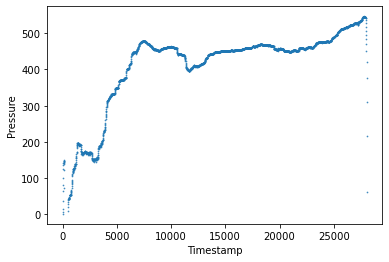

In [160]:
plot(f=parkinson_file_list[20],  plot_func=sns.regplot, t_id=0, x='Timestamp', y='Pressure')

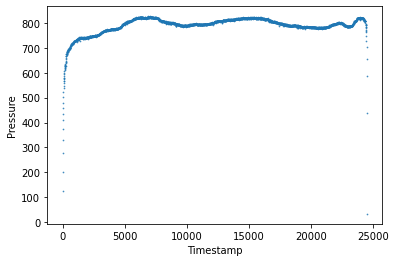

In [161]:
plot(control_file_list[1], plot_func=sns.regplot, t_id=0, x='Timestamp', y='Pressure')